# LASSO REGRESSION

In [31]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [32]:
df = pd.read_csv('clean_and_encoded_df.csv')

# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep = [col for col in df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_df = df[columns_to_keep]


baseline_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Andorra,Country_Angola,Country_Argentina,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,4.8,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,6.4,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.8,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,11.4,62820.0


In [33]:
df.Annual_salary.describe()

count      2805.000000
mean      78232.109447
std       50672.364092
min       10051.000000
25%       40525.000000
50%       66120.000000
75%      103242.000000
max      256000.000000
Name: Annual_salary, dtype: float64

Baseline model:

In [34]:
base_X = baseline_df.drop('Annual_salary', axis=1)
y = baseline_df['Annual_salary']
print(base_X.shape)
print(y.shape)

(2805, 138)
(2805,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(base_X, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
'''from scipy.stats import loguniform

lasso = Lasso()
param_dist = {'alpha': loguniform(10**(-4), 10**3)}  # Adjust the range of alpha values if needed

random_search_lasso = RandomizedSearchCV(lasso, param_dist, scoring='r2', n_iter=100, cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled, y_train)

best_alpha_random = random_search_lasso.best_params_['alpha']
best_score_random = random_search_lasso.best_score_
print(f"Best alpha (Randomized Search): {best_alpha_random}")
print(f"Best R2 score (Randomized Search): {best_score_random:.3f}")'''


'from scipy.stats import loguniform\n\nlasso = Lasso()\nparam_dist = {\'alpha\': loguniform(10**(-4), 10**3)}  # Adjust the range of alpha values if needed\n\nrandom_search_lasso = RandomizedSearchCV(lasso, param_dist, scoring=\'r2\', n_iter=100, cv=5, random_state=42)\nrandom_search_lasso.fit(X_train_scaled, y_train)\n\nbest_alpha_random = random_search_lasso.best_params_[\'alpha\']\nbest_score_random = random_search_lasso.best_score_\nprint(f"Best alpha (Randomized Search): {best_alpha_random}")\nprint(f"Best R2 score (Randomized Search): {best_score_random:.3f}")'

Hyperparameter tunning:

In [37]:
# With ADJ R2

k = 5
num_val_samples = len(X_train_scaled) // k
all_scores_r2_lasso = []
all_scores_rmse_lasso = []
all_scores_mae_lasso = []
all_scores_adj_r2_lasso = []

for i in range(k):
    print('processing fold #', i)
    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([X_train_scaled[:i * num_val_samples], X_train_scaled[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)

    model = Lasso(alpha=283)
    model.fit(partial_train_data, partial_train_targets)

    val_preds = model.predict(val_data)
    r2_val = r2_score(val_targets, val_preds)
    rmse_val = np.sqrt(mean_squared_error(val_targets, val_preds))
    mae_val = mean_absolute_error(val_targets, val_preds)

    n = len(val_data)
    p = partial_train_data.shape[1]
    adjusted_r2_val = 1 - (1 - r2_val) * (n - 1) / (n - p - 1)
    all_scores_adj_r2_lasso.append(adjusted_r2_val)

    all_scores_r2_lasso.append(r2_val)
    all_scores_rmse_lasso.append(rmse_val)
    all_scores_mae_lasso.append(mae_val)

mean_r2_lasso = np.mean(all_scores_r2_lasso)
std_r2_lasso = np.std(all_scores_r2_lasso)
mean_rmse_lasso = np.mean(all_scores_rmse_lasso)
std_rmse_lasso = np.std(all_scores_rmse_lasso)
mean_mae_lasso = np.mean(all_scores_mae_lasso)
std_mae_lasso = np.std(all_scores_mae_lasso)

mean_adj_r2_lasso = np.mean(all_scores_adj_r2_lasso)
std_adj_r2_lasso = np.std(all_scores_adj_r2_lasso)

print(f"Average R2 score (Lasso): {mean_r2_lasso:.3f} (+/- {std_r2_lasso:.3f})")
print(f"Average adjusted R2 score (Lasso): {mean_adj_r2_lasso:.3f} (+/- {std_adj_r2_lasso:.3f})")
print(f"Average RMSE score (Lasso): {mean_rmse_lasso:.3f} (+/- {std_rmse_lasso:.3f})")
print(f"Average MAE score (Lasso): {mean_mae_lasso:.3f} (+/- {std_mae_lasso:.3f})")



processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Average R2 score (Lasso): 0.608 (+/- 0.022)
Average adjusted R2 score (Lasso): 0.432 (+/- 0.032)
Average RMSE score (Lasso): 31649.660 (+/- 1107.090)
Average MAE score (Lasso): 23363.564 (+/- 1024.103)


In [38]:
lasso_results_dic = {}

lasso_results_dic['Lasso'] = {'R2': mean_r2_lasso, 'Adj R2': mean_adj_r2_lasso, 'RMSE': mean_rmse_lasso, 'MAE': mean_mae_lasso }
lasso_results = pd.DataFrame.from_dict(lasso_results_dic, orient='index')
lasso_results

,R2,Adj R2,RMSE,MAE
Lasso,0.6076,0.432354,31649.659805,23363.563915


In [39]:
lasso_results.to_csv('lasso_results.csv', index=True)

In [40]:
# Combine training and validation data sets
X_train_val = np.concatenate((X_train_scaled, val_data), axis=0)
y_train_val = np.concatenate((y_train, val_targets), axis=0)

# Train the model using the combined data set
model.fit(X_train_val, y_train_val)

# Make predictions on the test data set
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics on the test data set
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
n_test = len(X_test_scaled)
p_test = X_train_val.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f"R2 score on the test set (Lasso): {r2_test:.3f}")
print(f"Adjusted R2 score on the test set (Lasso): {adjusted_r2_test:.3f}")
print(f"RMSE score on the test set (Lasso): {rmse_test:.3f}")
print(f"MAE score on the test set (Lasso): {mae_test:.3f}")

R2 score on the test set (Lasso): 0.604
Adjusted R2 score on the test set (Lasso): 0.474
RMSE score on the test set (Lasso): 31917.415
MAE score on the test set (Lasso): 23581.393


In [41]:
test_results_dic = {}
test_results_dic['Lasso'] = {'R2': r2_test,  'Adj R2': adjusted_r2_test, 'RMSE': rmse_test, 'MAE': mae_test}
test_results = pd.DataFrame.from_dict(test_results_dic, orient='index')
test_results

,R2,Adj R2,RMSE,MAE
Lasso,0.603799,0.474235,31917.414576,23581.393358


In [42]:
test_results.to_csv('test_lasso_results.csv', index=True)

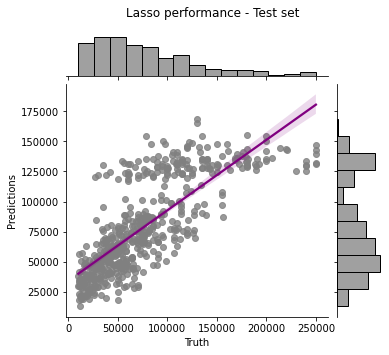

In [43]:

# Create a joint grid and configure the axes for the histograms
g = sns.JointGrid(x=y_test, y=y_pred, height=5)

# Create a scatter plot and fit a linear regression line to the data
g.plot_joint(sns.regplot, scatter_kws={'color': 'grey'}, line_kws={'color': 'purple'})

# Add histograms on the top and right side of the plot
g.plot_marginals(sns.histplot, kde=False, color='grey')

# Adjust the spacing between the subplots and move the title up
g.fig.subplots_adjust(top=0.9)

# Add title
g.fig.suptitle("Lasso performance - Test set")

# Label the axes
g.ax_joint.set_xlabel("Truth")
g.ax_joint.set_ylabel("Predictions")

plt.show()


In [44]:
# Fit the Lasso model using the best alpha value and the entire training set
best_alpha_lasso = 283
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train_scaled, y_train)

# Get the feature coefficients
coefficients = lasso_model.coef_

# Get the feature names from the DataFrame
feature_names = X_train.columns

# Print the coefficients and the corresponding feature names
for coef, feature in zip(coefficients, feature_names):
    print(f"{feature}: {coef:.3f}")

# Get the features with non-zero coefficients
selected_features = [feature for coef, feature in zip(coefficients, feature_names) if coef != 0]
print(f"\nSelected features by Lasso: {selected_features}")

Education: 2982.556
Company_size: 1984.335
Age: 1078.573
Job_type_Full-time employed: 0.000
Job_type_Independent contractor / Freelancer / Self-employed: 288.098
Job_type_Other: -0.000
Job_type_Part-time employed: -1906.105
Country_Andorra: -55.427
Country_Angola: 0.000
Country_Argentina: -1941.107
Country_Armenia: -0.000
Country_Australia: 5993.034
Country_Austria: 521.036
Country_Azerbaijan: 0.000
Country_Bangladesh: -351.424
Country_Barbados: -126.765
Country_Belarus: 83.668
Country_Belgium: -0.000
Country_Bosnia-Herz.: -418.606
Country_Botswana: -434.733
Country_Brazil: -3118.974
Country_Bulgaria: -505.227
Country_Canada: 7275.009
Country_Chile: -530.126
Country_China: 1049.934
Country_Colombia: -1703.130
Country_Costa Rica: 0.000
Country_Croatia: -709.597
Country_Cyprus: -98.786
Country_Czech Republic: -133.729
Country_CÃ´te d'Ivoire: -123.256
Country_Denmark: 2634.012
Country_Dominican Republic: -208.864
Country_Ecuador: -336.122
Country_Egypt: -999.284
Country_El Salvador: -191.

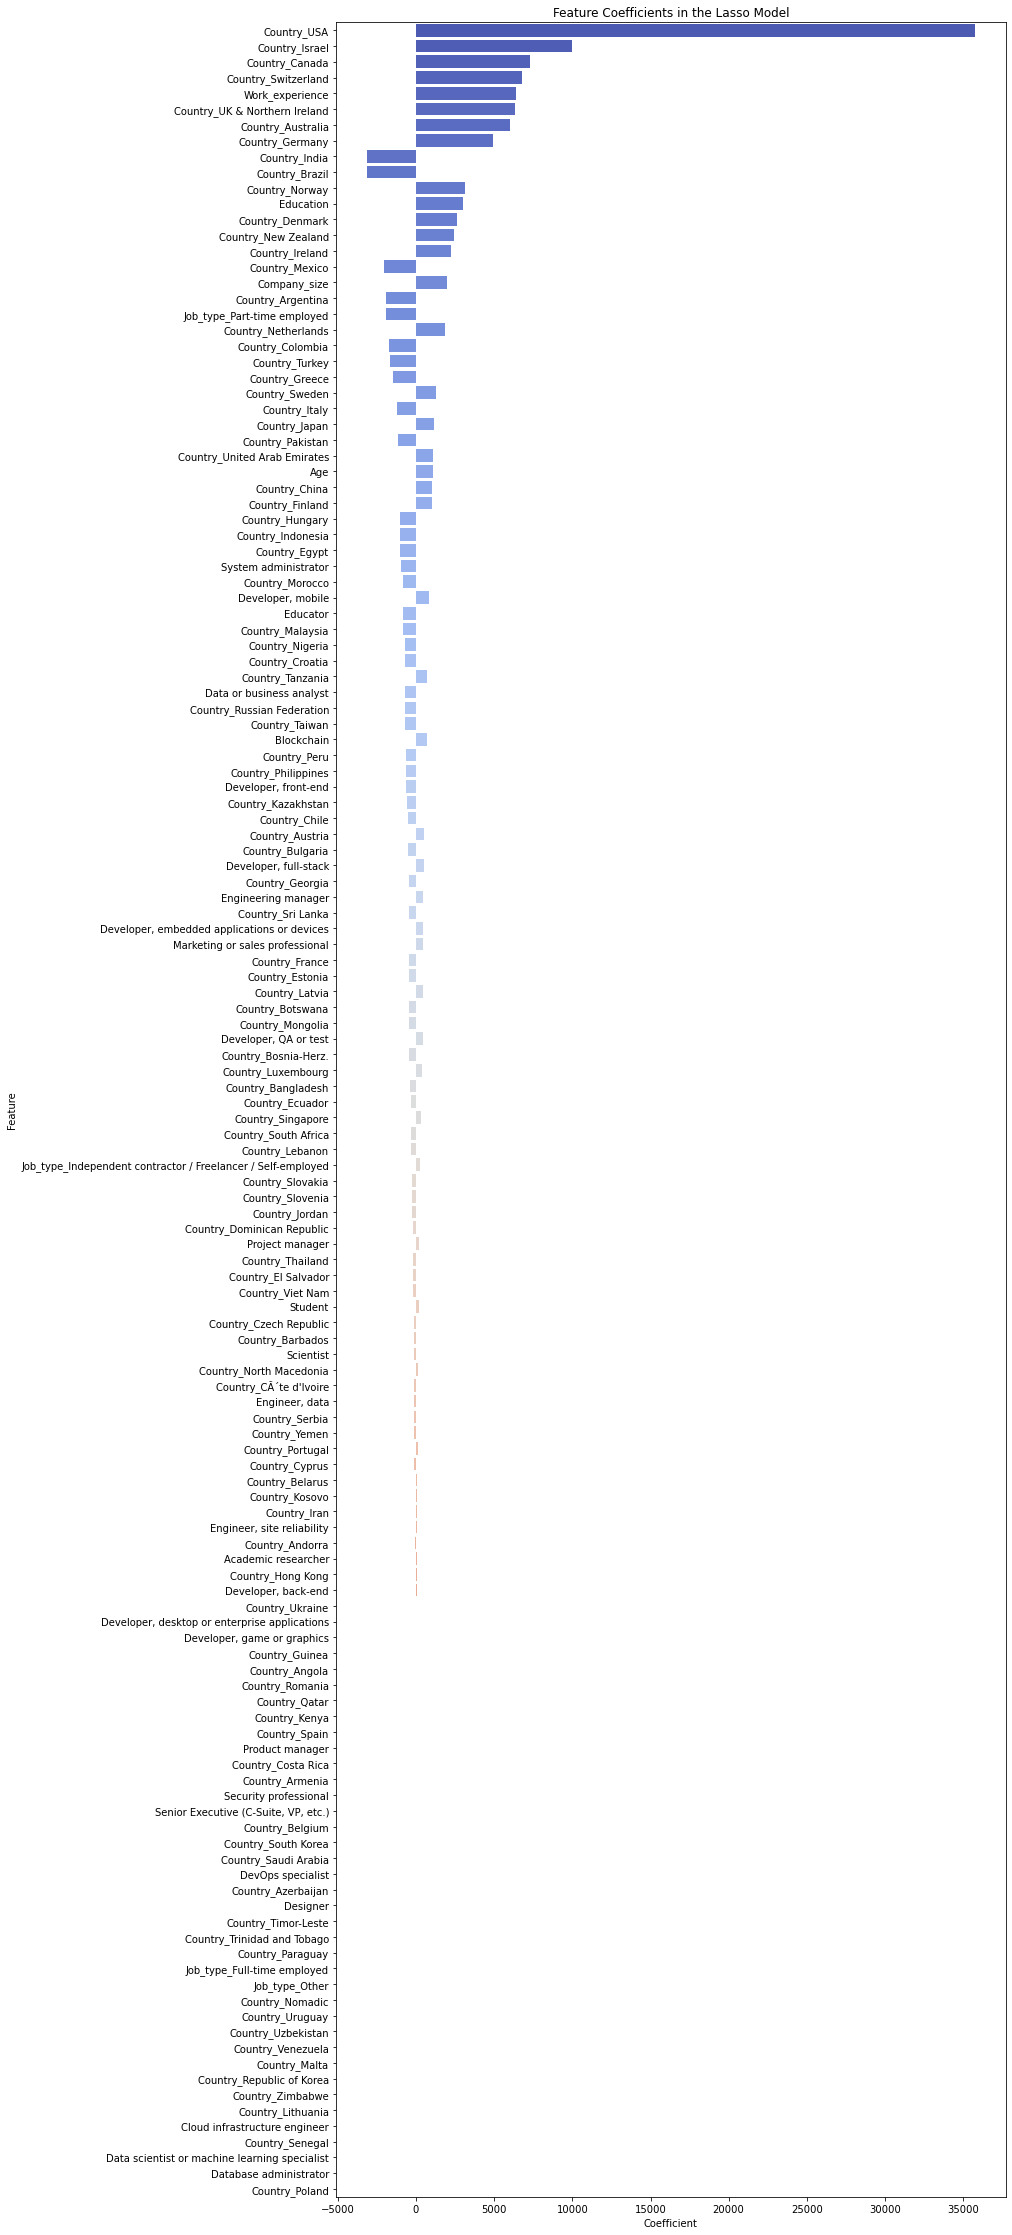

In [45]:
import seaborn as sns

# Create a DataFrame with the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefficients})

# Sort the DataFrame by the absolute value of the coefficients in descending order
coef_df = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)

# Create a bar plot of the feature coefficients
plt.figure(figsize=(12, 40))
sns.barplot(data=coef_df, x='coef', y='feature', palette='coolwarm')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients in the Lasso Model')
plt.show()
